<a href="https://colab.research.google.com/github/Shallom12/Autonomous-driving-of-Chungnam-Human-Resources-Development-Institute/blob/main/opencv_autonomus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python tensorflow scikit-learn matplotlib pillow
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
class AutonomousDrivingMLSystem:
    def __init__(self):
        self.lane_detector = None
        self.traffic_sign_classifier = None
        self.speed_predictor = None

    def preprocess_image(self, image_path):
        """이미지 전처리 함수"""
        image = cv2.imread(image_path)
        if image is None:
            return None

        # 크기 조정
        image = cv2.resize(image, (224, 224))
        # 정규화
        image = image.astype(np.float32) / 255.0
        return image

    def detect_lane_features(self, image):
        """차선 특징 추출"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 가우시안 블러 적용
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blur, 50, 150)

        # 관심 영역 설정 (도로 하단부)
        height = edges.shape[0]
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (edges.shape[1], height),
            (edges.shape[1], height//2),
            (0, height//2)
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        # 허프 변환으로 직선 검출
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180,
                               threshold=50, minLineLength=100, maxLineGap=50)

        features = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # 기울기와 길이 계산
                if x2 - x1 != 0:
                    slope = (y2 - y1) / (x2 - x1)
                    length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    features.extend([slope, length, x1, y1, x2, y2])

        # 고정 길이로 맞추기
        while len(features) < 30:
            features.append(0)
        return features[:30]

    def build_traffic_sign_cnn(self):
        """교통 표지판 분류를 위한 CNN 모델"""
        model = models.Sequential([
            layers.Input(shape=(64, 64, 3)),  # Explicitly add Input layer
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4, activation='softmax')  # 4개 클래스: 정지, 직진, 좌회전, 우회전
        ])

        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def generate_sample_data(self):
        """샘플 데이터 생성 (실제로는 실제 도로 이미지를 사용)"""
        # 차선 특징 데이터 생성
        np.random.seed(42)
        lane_features = []
        lane_decisions = []

        for i in range(1000):
            # 30개 특징 (기울기, 길이, 좌표 등)
            features = np.random.randn(30)

            # 차선 중앙 유지 여부 결정 (0: 좌회전, 1: 직진, 2: 우회전)
            if features[0] < -0.5:  # 왼쪽 기울기가 강함
                decision = 0  # 우회전으로 보정
            elif features[0] > 0.5:  # 오른쪽 기울기가 강함
                decision = 2  # 좌회전으로 보정
            else:
                decision = 1  # 직진

            lane_features.append(features)
            lane_decisions.append(decision)

        # 교통 표지판 이미지 데이터 생성 (실제로는 실제 표지판 이미지)
        sign_images = np.random.rand(500, 64, 64, 3)
        sign_labels = np.random.randint(0, 4, 500)

        return np.array(lane_features), np.array(lane_decisions), sign_images, sign_labels

    def train_lane_keeping_system(self):
        """차선 유지 시스템 훈련"""
        print("차선 유지 시스템 훈련 시작...")

        # 샘플 데이터 생성
        lane_features, lane_decisions, _, _ = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            lane_features, lane_decisions, test_size=0.2, random_state=42
        )

        # 랜덤 포레스트 분류기 훈련
        self.lane_detector = RandomForestClassifier(n_estimators=100, random_state=42)
        self.lane_detector.fit(X_train, y_train)

        # 성능 평가
        y_pred = self.lane_detector.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"차선 유지 시스템 정확도: {accuracy:.3f}")
        print("\n분류 보고서:")
        print(classification_report(y_test, y_pred,
                                   target_names=['좌회전', '직진', '우회전']))

        return accuracy

    def train_traffic_sign_classifier(self):
        """교통 표지판 분류기 훈련"""
        print("\n교통 표지판 분류기 훈련 시작...")

        # 샘플 데이터 생성
        _, _, sign_images, sign_labels = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            sign_images, sign_labels, test_size=0.2, random_state=42
        )

        # CNN 모델 생성 및 훈련
        self.traffic_sign_classifier = self.build_traffic_sign_cnn()

        history = self.traffic_sign_classifier.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # 성능 평가
        test_loss, test_accuracy = self.traffic_sign_classifier.evaluate(X_test, y_test, verbose=0)
        print(f"\n교통 표지판 분류 정확도: {test_accuracy:.3f}")

        return test_accuracy

    def predict_driving_action(self, image_path):
        """주행 행동 예측"""
        if not os.path.exists(image_path):
            print("이미지 파일을 찾을 수 없습니다.")
            return None

        # 이미지 전처리
        image = self.preprocess_image(image_path)
        if image is None:
            return None

        # 차선 특징 추출
        lane_features = self.detect_lane_features((image * 255).astype(np.uint8))

        # 차선 기반 주행 방향 예측
        if self.lane_detector:
            lane_decision = self.lane_detector.predict([lane_features])[0]
            lane_actions = ['좌회전', '직진', '우회전']

            print(f"차선 분석 결과: {lane_actions[lane_decision]}")

        # 교통 표지판 분류 (64x64 크기로 조정)
        if self.traffic_sign_classifier:
            sign_image = cv2.resize((image * 255).astype(np.uint8), (64, 64))
            sign_image = np.expand_dims(sign_image.astype(np.float32) / 255.0, axis=0)

            sign_prediction = self.traffic_sign_classifier.predict(sign_image, verbose=0)
            sign_class = np.argmax(sign_prediction[0])
            sign_confidence = np.max(sign_prediction[0])

            sign_names = ['정지', '직진', '좌회전', '우회전']
            print(f"교통표지판 인식: {sign_names[sign_class]} (신뢰도: {sign_confidence:.3f})")

        return lane_decision if self.lane_detector else None

def main():
    """메인 실행 함수"""
    print("=== 자율주행 지도학습 시스템 ===\n")

    # 시스템 초기화
    autonomous_system = AutonomousDrivingMLSystem()

    # 모델 훈련
    lane_accuracy = autonomous_system.train_lane_keeping_system()
    sign_accuracy = autonomous_system.train_traffic_sign_classifier()

    print(f"\n=== 훈련 완료 ===")
    print(f"차선 유지 시스템 정확도: {lane_accuracy:.1%}")
    print(f"교통표지판 분류 정확도: {sign_accuracy:.1%}")

    # 샘플 이미지로 테스트 (실제 파일이 있다면)
    # test_image = "sample_road.jpg"
    # result = autonomous_system.predict_driving_action(test_image)

if __name__ == "__main__":
    main()

=== 자율주행 지도학습 시스템 ===

차선 유지 시스템 훈련 시작...
차선 유지 시스템 정확도: 1.000

분류 보고서:
              precision    recall  f1-score   support

         좌회전       1.00      1.00      1.00        69
          직진       1.00      1.00      1.00        72
         우회전       1.00      1.00      1.00        59

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


교통 표지판 분류기 훈련 시작...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.2641 - loss: 1.4035 - val_accuracy: 0.2200 - val_loss: 1.3927
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.1980 - loss: 1.3974 - val_accuracy: 0.3000 - val_loss: 1.3872
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.2495 - loss: 1.3867 - val_accuracy: 0.2900 - val_loss: 1.3865
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.3093 - loss: 1.3859 - val_accuracy: 0.2800 - val_loss: 1.3867
Epoch 5/10
13/

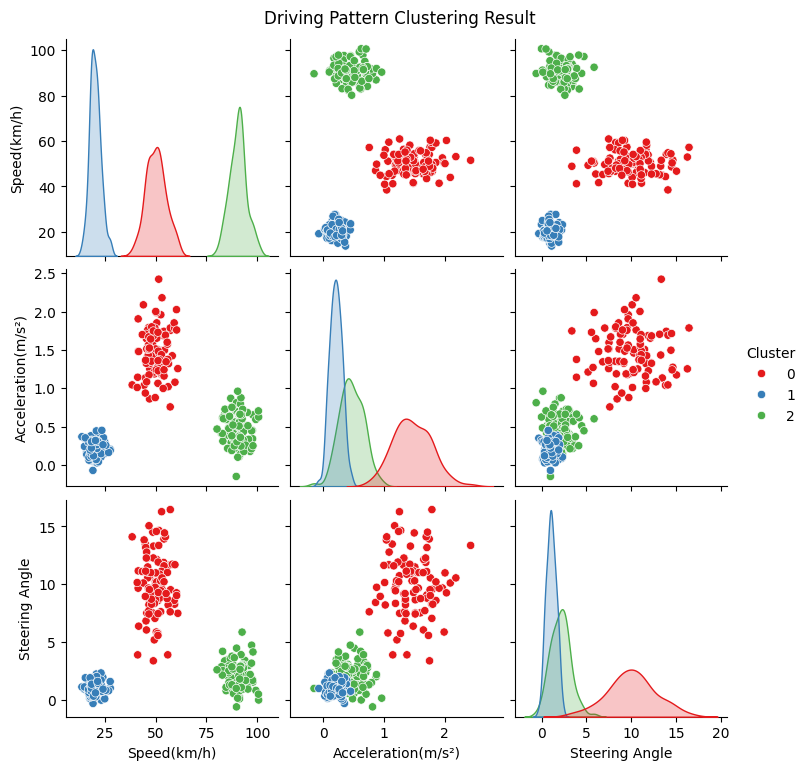

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 샘플 자율주행 데이터 생성
np.random.seed(42)
n_samples = 300

# # 고속도로 주행 데이터
# 속도 평균 90km/h, 가속도 낮음(0.5), 핸들 조작 작음(2도)
# 고속도로에서 비교적 일직선, 빠른 주행 특징
highway = np.random.normal(loc=[90, 0.5, 2], scale=[5, 0.2, 1], size=(100, 3))

#비슷하게 city(도심), traffic(정체) 데이터도 생성합니다:
city = np.random.normal(loc=[50, 1.5, 10], scale=[5, 0.3, 3], size=(100, 3))
traffic = np.random.normal(loc=[20, 0.2, 1], scale=[3, 0.1, 0.5], size=(100, 3))

data = np.vstack((highway, city, traffic))
df = pd.DataFrame(data, columns=['Speed(km/h)', 'Acceleration(m/s²)', 'Steering Angle'])

# 🔹 2단계: 데이터 정규화
# 정규화(표준화): 데이터 값들의 단위를 맞춰줌

# 이유: 어떤 값은 90(속도), 어떤 값은 0.5(가속도)처럼 범위가 달라서 공정한 비교가 안 됨
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 3단계: K-Means 클러스터링
# K=3: 우리는 3가지 패턴(고속, 도심, 정체)을 원한다고 설정

# K-Means가 데이터를 자동으로 3개의 그룹으로 나눔
#사람이 라벨을 붙이지 않아도, 머신이 비슷한 운전 스타일끼리 묶음
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# 시각화
# 각 클러스터(분류된 그룹)를 색깔로 구분해서 보여줍니다

# 예: 파란 점은 고속도로, 빨간 점은 도심, 초록 점은 정체 운전
sns.pairplot(df, hue='Cluster', palette='Set1')
plt.suptitle('Driving Pattern Clustering Result', y=1.02)
plt.show()


In [ ]:
# OpenCV 교통표지판 인식 (훈련 불필요!)
!pip install opencv-python matplotlib pillow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.1 MB/s eta 0:00:00


In [ ]:

# 한글 폰트 설정 (Colab용)
import matplotlib.font_manager as fm
# Colab에서 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 6s (1,717 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 122151 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

🚗 OpenCV 교통표지판 인식 시스템
🎯 특징: 훈련 불필요, 즉시 인식!
🔍 방법: 색상 + 모양 + 텍스트 패턴 분석
📊 인식 가능: 정지, 지시, 경고, 안내 표지판
📷 교통표지판 이미지를 업로드해주세요!


Saving KakaoTalk_Photo_2025-07-07-12-15-45.jpeg to KakaoTalk_Photo_2025-07-07-12-15-45.jpeg
Saving stop-634941_1280.jpg to stop-634941_1280.jpg

🔍 'KakaoTalk_Photo_2025-07-07-12-15-45.jpeg' 분석 중...

🎯 분석 결과: unknown_sign
📐 검출된 모양: rectangle_guide_sign
📝 텍스트 정보: ['text_included_stop_possible']
🔍 Debug: 'unknown_sign' → 'Unknown Sign'


/tmp/ipython-input-11-2994757847.py:285: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


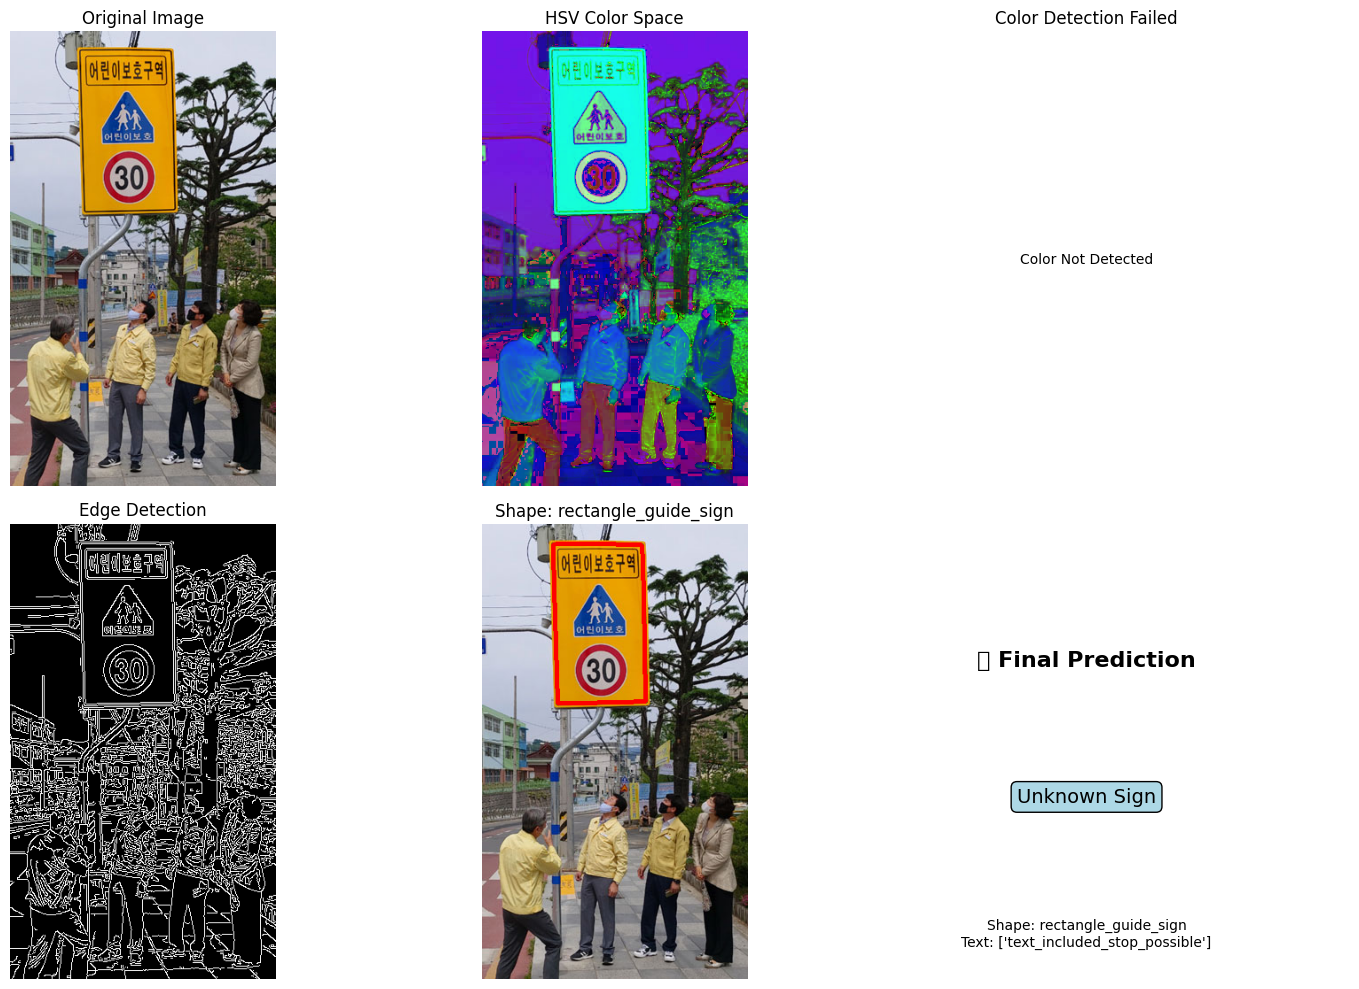

--------------------------------------------------

🔍 'stop-634941_1280.jpg' 분석 중...

🎯 분석 결과: caution_sign
🎨 검출된 색상: yellow (21.5%)
📐 검출된 모양: octagon_stop_sign
📝 텍스트 정보: ['text_included_stop_possible']
🔍 Debug: 'caution_sign' → 'Caution Sign'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


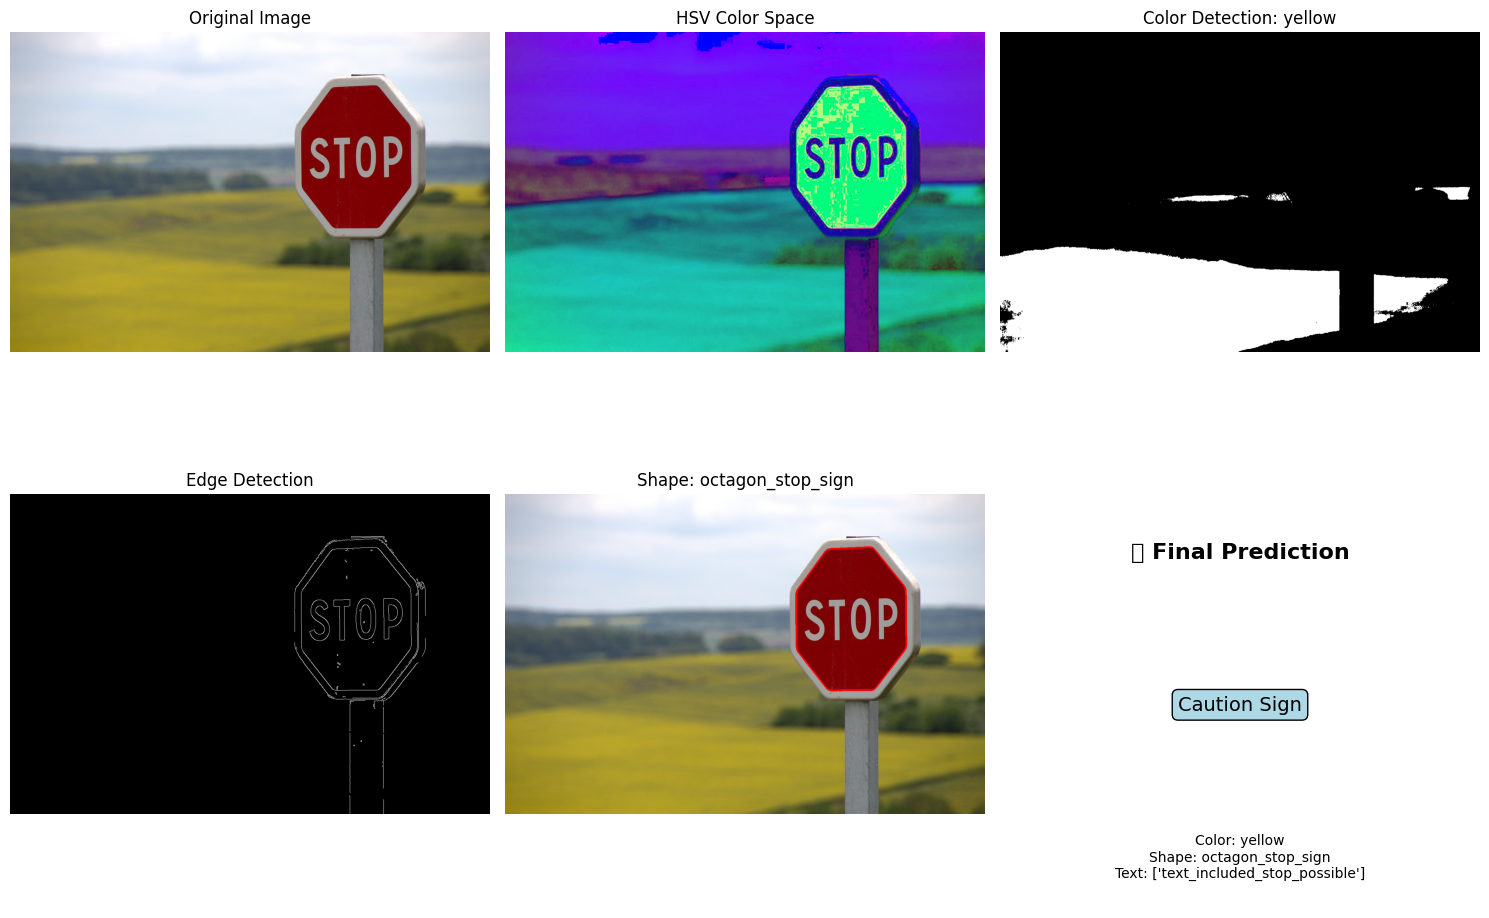

--------------------------------------------------

🔄 다른 이미지도 분석하시겠어요? (y/n): ㅛ

🎉 OpenCV 교통표지판 인식 완료!


In [ ]:
class OpenCVTrafficSignRecognizer:
    def __init__(self):
        # 색상 범위 정의 (HSV 색공간)
        self.color_ranges = {
            'red': {
                'lower1': np.array([0, 120, 70]),    # 빨간색 범위1
                'upper1': np.array([10, 255, 255]),
                'lower2': np.array([170, 120, 70]),  # 빨간색 범위2
                'upper2': np.array([180, 255, 255]),
                'sign_type': 'stop_prohibition'
            },
            'blue': {
                'lower': np.array([90, 100, 50]),    # 파란색
                'upper': np.array([150, 255, 255]),
                'sign_type': 'direction_guide'
            },
            'yellow': {
                'lower': np.array([15, 150, 150]),   # 노란색
                'upper': np.array([35, 255, 255]),
                'sign_type': 'warning_caution'
            },
            'green': {
                'lower': np.array([40, 150, 100]),   # 초록색
                'upper': np.array([80, 255, 255]),
                'sign_type': 'safety_permission'
            }
        }

    def detect_color(self, image):
        """색상 기반 표지판 분류"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        detected_colors = []

        for color_name, color_info in self.color_ranges.items():
            if color_name == 'red':
                # 빨간색은 HSV에서 두 범위로 나뉨
                mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
                mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
                mask = cv2.bitwise_or(mask1, mask2)
            else:
                mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

            # 색상 픽셀 수 계산
            color_pixels = cv2.countNonZero(mask)
            total_pixels = image.shape[0] * image.shape[1]
            color_ratio = color_pixels / total_pixels

            if color_ratio > 0.1:  # 10% 이상이면 해당 색상으로 판정
                detected_colors.append({
                    'color': color_name,
                    'ratio': color_ratio,
                    'sign_type': color_info['sign_type'],
                    'mask': mask
                })

        # 가장 많은 색상 반환
        if detected_colors:
            return max(detected_colors, key=lambda x: x['ratio'])
        return None

    def detect_shapes(self, image):
        """모양 기반 표지판 분류"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 가우시안 블러 적용
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blurred, 50, 150)

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shapes = []

        for contour in contours:
            # 작은 컨투어 무시
            if cv2.contourArea(contour) < 500:
                continue

            # 컨투어 근사화
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # 꼭짓점 수로 모양 판별
            vertices = len(approx)

            # 모양 분류
            if vertices == 3:
                shape_type = "triangle_warning_sign"
            elif vertices == 4:
                # 사각형인지 확인
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.95 <= aspect_ratio <= 1.05:
                    shape_type = "square_general_sign"
                else:
                    shape_type = "rectangle_guide_sign"
            elif 5 <= vertices <= 10:
                shape_type = "octagon_stop_sign"
            else:
                # 원형 여부 확인
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter > 0:
                    circularity = 4 * np.pi * area / (perimeter * perimeter)
                    if circularity > 0.7:
                        shape_type = "circle_direction_sign"
                    else:
                        shape_type = "other_shape"
                else:
                    shape_type = "other_shape"

            shapes.append({
                'shape': shape_type,
                'vertices': vertices,
                'area': cv2.contourArea(contour),
                'contour': contour
            })

        # 가장 큰 모양 반환
        if shapes:
            return max(shapes, key=lambda x: x['area'])
        return None

    def detect_text_patterns(self, image):
        """텍스트 패턴 인식 (간단한 템플릿 매칭)"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 이진화
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

        # STOP 텍스트 특징 검사 (간단한 방법)
        # 중앙 영역의 백색 픽셀 패턴 확인
        h, w = binary.shape
        center_region = binary[h//3:2*h//3, w//4:3*w//4]
        white_pixels = cv2.countNonZero(center_region)
        total_pixels = center_region.shape[0] * center_region.shape[1]

        text_patterns = []

        if white_pixels / total_pixels > 0.3:  # 30% 이상 흰 픽셀
            text_patterns.append("text_included_stop_possible")

        return text_patterns

    def classify_traffic_sign(self, image):
        """종합적인 교통표지판 분류"""
        # 1. 색상 검출
        color_result = self.detect_color(image)

        # 2. 모양 검출
        shape_result = self.detect_shapes(image)

        # 3. 텍스트 패턴 검출
        text_result = self.detect_text_patterns(image)

        # 4. 종합 판단
        classification = {
            'color_info': color_result,
            'shape_info': shape_result,
            'text_info': text_result,
            'final_prediction': 'unknown_sign'
        }

        # 규칙 기반 분류
        if color_result and shape_result:
            color = color_result['color']
            shape = shape_result['shape']

            if color == 'red':
                if 'octagon' in shape or 'text_included' in str(text_result):
                    classification['final_prediction'] = 'stop_sign'
                else:
                    classification['final_prediction'] = 'prohibition_sign'
            elif color == 'blue':
                if 'circle' in shape:
                    classification['final_prediction'] = 'direction_sign'
                else:
                    classification['final_prediction'] = 'guide_sign'
            elif color == 'yellow':
                if 'triangle' in shape:
                    classification['final_prediction'] = 'warning_sign'
                else:
                    classification['final_prediction'] = 'caution_sign'
            elif color == 'green':
                classification['final_prediction'] = 'safety_sign'

        elif color_result:
            # 색상만으로 판단
            if color_result['sign_type'] == 'stop_prohibition':
                classification['final_prediction'] = 'stop_sign'
            elif color_result['sign_type'] == 'direction_guide':
                classification['final_prediction'] = 'direction_sign'
            elif color_result['sign_type'] == 'warning_caution':
                classification['final_prediction'] = 'warning_sign'
            elif color_result['sign_type'] == 'safety_permission':
                classification['final_prediction'] = 'safety_sign'
            else:
                classification['final_prediction'] = color_result['sign_type']

        elif shape_result:
            # 모양만으로 판단
            if 'octagon' in shape_result['shape']:
                classification['final_prediction'] = 'stop_sign_by_shape'
            elif 'triangle' in shape_result['shape']:
                classification['final_prediction'] = 'warning_sign_by_shape'
            elif 'circle' in shape_result['shape']:
                classification['final_prediction'] = 'direction_sign_by_shape'

        return classification

    def visualize_detection(self, image, classification):
        """검출 결과 시각화"""
        plt.figure(figsize=(15, 10))

        # 1. 원본 이미지
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # 2. HSV 이미지
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        plt.subplot(2, 3, 2)
        plt.imshow(hsv)
        plt.title('HSV Color Space')
        plt.axis('off')

        # 3. 색상 마스크
        plt.subplot(2, 3, 3)
        if classification['color_info']:
            plt.imshow(classification['color_info']['mask'], cmap='gray')
            plt.title(f"Color Detection: {classification['color_info']['color']}")
        else:
            plt.text(0.5, 0.5, 'Color Not Detected', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Color Detection Failed')
        plt.axis('off')

        # 4. 에지 검출
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        plt.subplot(2, 3, 4)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        # 5. 모양 검출
        plt.subplot(2, 3, 5)
        shape_image = image.copy()
        if classification['shape_info']:
            cv2.drawContours(shape_image, [classification['shape_info']['contour']], -1, (255, 0, 0), 3)
            plt.imshow(shape_image)
            plt.title(f"Shape: {classification['shape_info']['shape']}")
        else:
            plt.imshow(image)
            plt.title('Shape Not Detected')
        plt.axis('off')

        # 6. 최종 결과
        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.7, '🎯 Final Prediction', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

        # 영어 예측 결과를 읽기 쉬운 영어로 변환해서 표시
        prediction_english = self.convert_prediction_to_english(classification['final_prediction'])
        plt.text(0.5, 0.4, prediction_english, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        # 상세 정보 (영어로)
        details = ""
        if classification['color_info']:
            details += f"Color: {classification['color_info']['color']}\n"
        if classification['shape_info']:
            details += f"Shape: {classification['shape_info']['shape']}\n"
        if classification['text_info']:
            details += f"Text: {classification['text_info']}"

        plt.text(0.5, 0.1, details, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def convert_prediction_to_english(self, prediction):
        """영어 예측 결과를 더 읽기 쉬운 영어로 변환"""
        conversion_dict = {
            'stop_sign': 'STOP Sign',
            'direction_sign': 'Direction Sign',
            'warning_sign': 'Warning Sign',
            'caution_sign': 'Caution Sign',
            'safety_sign': 'Safety Sign',
            'prohibition_sign': 'Prohibition Sign',
            'guide_sign': 'Guide Sign',
            'stop_sign_by_shape': 'STOP Sign (by shape)',
            'warning_sign_by_shape': 'Warning Sign (by shape)',
            'direction_sign_by_shape': 'Direction Sign (by shape)',
            'unknown_sign': 'Unknown Sign',
            'stop_prohibition': 'STOP/Prohibition Sign',
            'direction_guide': 'Direction/Guide Sign',
            'warning_caution': 'Warning/Caution Sign',
            'safety_permission': 'Safety/Permission Sign'
        }

        result = conversion_dict.get(prediction, f'Unclassified: {prediction}')
        print(f"🔍 Debug: '{prediction}' → '{result}'")
        return result

    def upload_and_analyze(self):
        """이미지 업로드 및 분석"""
        print("📷 교통표지판 이미지를 업로드해주세요!")
        print("=" * 50)

        uploaded = files.upload()

        if not uploaded:
            print("❌ 업로드된 파일이 없습니다.")
            return

        for filename, file_data in uploaded.items():
            print(f"\n🔍 '{filename}' 분석 중...")

            try:
                # 이미지 로드
                image = Image.open(io.BytesIO(file_data))
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                image_array = np.array(image)

                # 분석 수행
                result = self.classify_traffic_sign(image_array)

                # 결과 출력
                print(f"\n🎯 분석 결과: {result['final_prediction']}")

                if result['color_info']:
                    print(f"🎨 검출된 색상: {result['color_info']['color']} ({result['color_info']['ratio']:.1%})")

                if result['shape_info']:
                    print(f"📐 검출된 모양: {result['shape_info']['shape']}")

                if result['text_info']:
                    print(f"📝 텍스트 정보: {result['text_info']}")

                # 시각화
                self.visualize_detection(image_array, result)

                print("-" * 50)

            except Exception as e:
                print(f"❌ 오류 발생: {e}")

def main():
    """메인 실행 함수"""
    print("🚗 OpenCV 교통표지판 인식 시스템")
    print("=" * 50)
    print("🎯 특징: 훈련 불필요, 즉시 인식!")
    print("🔍 방법: 색상 + 모양 + 텍스트 패턴 분석")
    print("📊 인식 가능: 정지, 지시, 경고, 안내 표지판")
    print("=" * 50)

    # 시스템 초기화
    recognizer = OpenCVTrafficSignRecognizer()

    # 이미지 분석
    while True:
        recognizer.upload_and_analyze()

        continue_choice = input("\n🔄 다른 이미지도 분석하시겠어요? (y/n): ")
        if continue_choice.lower() != 'y':
            break

    print("\n🎉 OpenCV 교통표지판 인식 완료!")

if __name__ == "__main__":
    main()

🎉 OpenCV 버전: 4.11.0

🎨 테스트 1: 이미지 생성하기


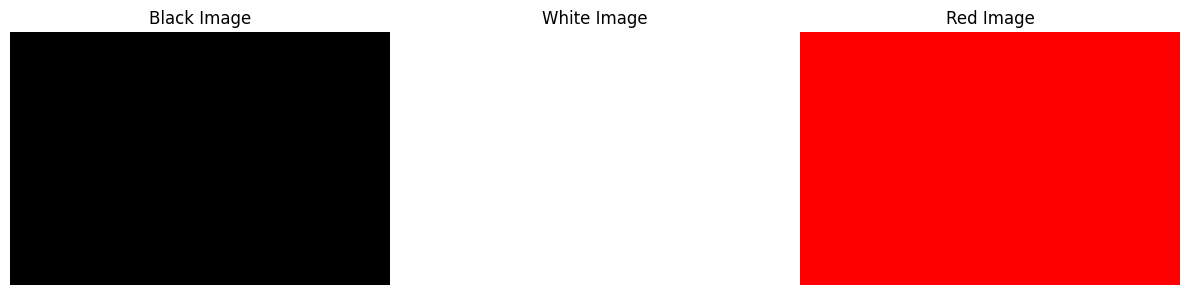

In [ ]:
# OpenCV 초보자 테스트 코드 - Colab에서 실행하세요!

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

print(f"🎉 OpenCV 버전: {cv2.__version__}")

# =============================================================================
# 📝 테스트 1: 간단한 이미지 생성하기
# =============================================================================

def test1_create_image():
    """간단한 이미지 만들어보기"""
    print("\n🎨 테스트 1: 이미지 생성하기")

    # 1. 빈 캔버스 만들기 (검은색)
    black_img = np.zeros((200, 300, 3), dtype=np.uint8)

    # 2. 흰색 캔버스 만들기
    white_img = np.ones((200, 300, 3), dtype=np.uint8) * 255

    # 3. 빨간색 캔버스 만들기
    red_img = np.zeros((200, 300, 3), dtype=np.uint8)
    red_img[:, :, 2] = 255  # BGR에서 R채널

    # 결과 출력
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(black_img)
    plt.title('Black Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(white_img)
    plt.title('White Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(red_img, cv2.COLOR_BGR2RGB))
    plt.title('Red Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# 함수 실행 코드 추가
if __name__ == "__main__":
    test1_create_image()



🔺 테스트 2: 도형 그리기


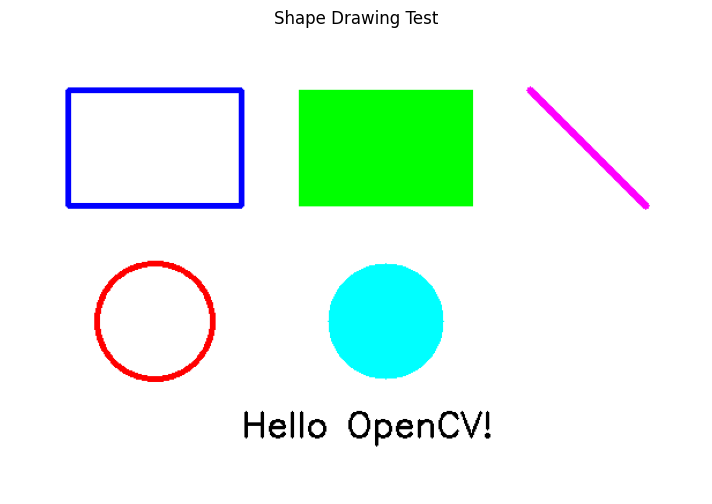

In [ ]:
# =============================================================================
# 📝 테스트 2: 도형 그리기
# =============================================================================

def test2_draw_shapes():
    """도형 그리기 연습"""
    print("\n🔺 테스트 2: 도형 그리기")

    # 캔버스 생성
    canvas = np.ones((400, 600, 3), dtype=np.uint8) * 255

    # 1. 사각형 그리기
    cv2.rectangle(canvas, (50, 50), (200, 150), (255, 0, 0), 3)  # 파란색 테두리
    cv2.rectangle(canvas, (250, 50), (400, 150), (0, 255, 0), -1)  # 초록색 채우기

    # 2. 원 그리기
    cv2.circle(canvas, (125, 250), 50, (0, 0, 255), 3)  # 빨간색 테두리
    cv2.circle(canvas, (325, 250), 50, (255, 255, 0), -1)  # 노란색 채우기

    # 3. 직선 그리기
    cv2.line(canvas, (450, 50), (550, 150), (255, 0, 255), 5)  # 보라색 선

    # 4. 텍스트 쓰기
    cv2.putText(canvas, 'Hello OpenCV!', (200, 350),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # 결과 출력
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title('Shape Drawing Test')
    plt.axis('off')
    plt.show()

# 함수 실행 코드 추가
if __name__ == "__main__":
    test2_draw_shapes()


🌈 테스트 3: 색상 변환


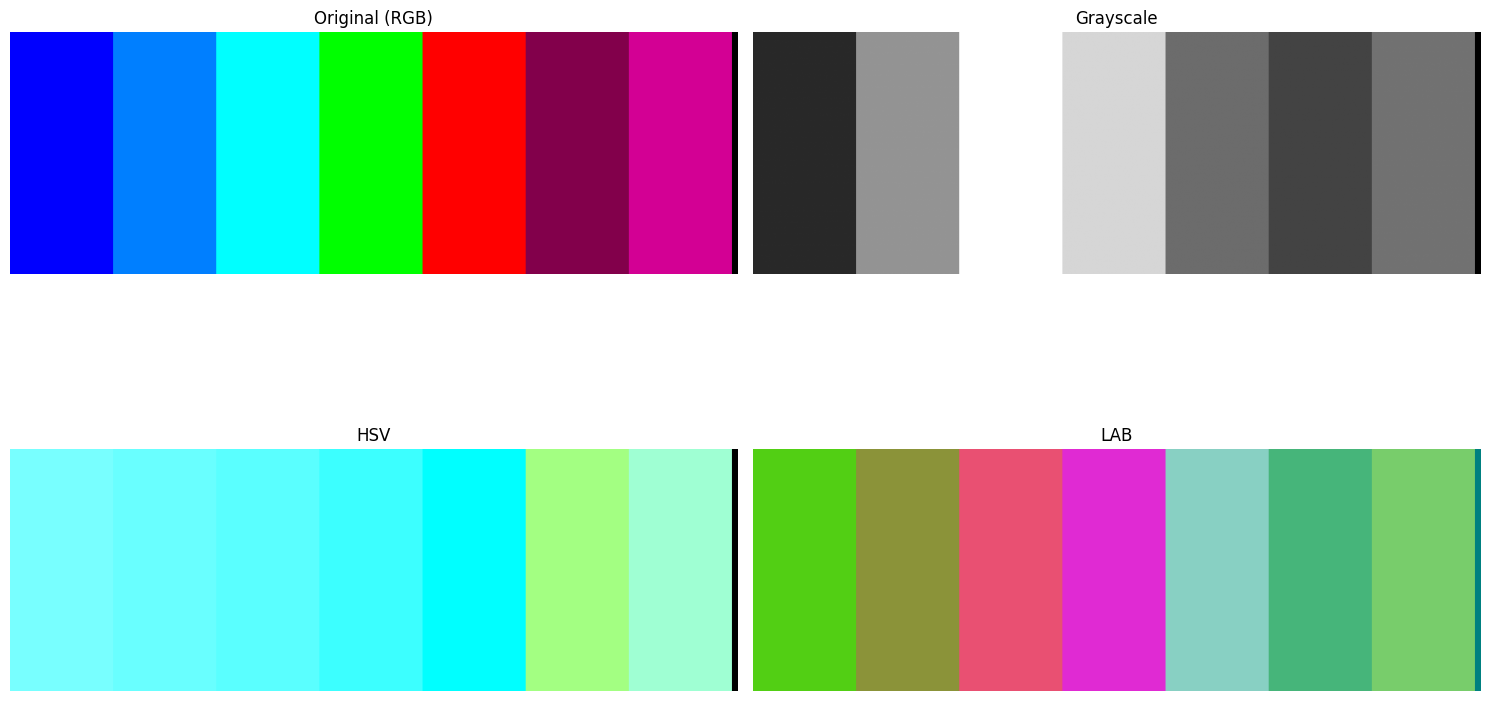

In [ ]:
# =============================================================================
# 📝 테스트 3: 색상 변환
# =============================================================================

def test3_color_conversion():
    """색상 변환 테스트"""
    print("\n🌈 테스트 3: 색상 변환")

    # 컬러 이미지 생성 (무지개 패턴)
    img = np.zeros((200, 600, 3), dtype=np.uint8)

    # 무지개 색상 만들기
    colors = [
        (255, 0, 0),    # 빨강
        (255, 127, 0),  # 주황
        (255, 255, 0),  # 노랑
        (0, 255, 0),    # 초록
        (0, 0, 255),    # 파랑
        (75, 0, 130),   # 남색
        (148, 0, 211)   # 보라
    ]

    # 각 색상을 세로 띠로 만들기
    strip_width = 600 // len(colors)
    for i, color in enumerate(colors):
        x_start = i * strip_width
        x_end = (i + 1) * strip_width
        img[:, x_start:x_end] = color

    # 다양한 색공간으로 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 결과 출력
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original (RGB)')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(hsv)
    plt.title('HSV')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(lab)
    plt.title('LAB')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 함수 실행 코드 추가
if __name__ == "__main__":
    test3_color_conversion()


🔍 테스트 4: 이미지 필터링


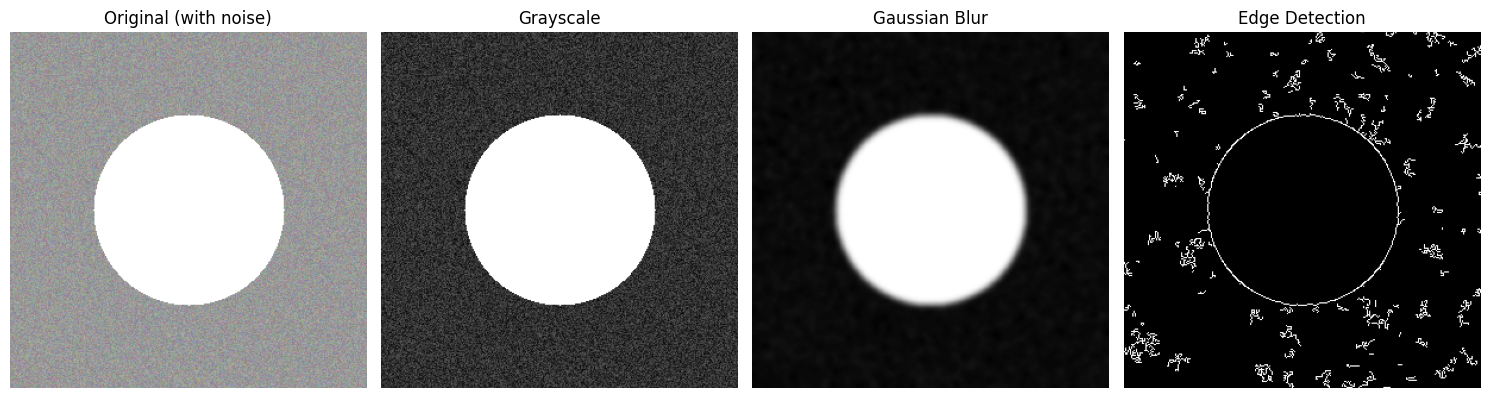

In [ ]:
# =============================================================================
# 📝 테스트 4: 이미지 필터링
# =============================================================================

def test4_image_filtering():
    """이미지 필터링 테스트"""
    print("\n🔍 테스트 4: 이미지 필터링")

    # 노이즈가 있는 이미지 생성
    img = np.ones((300, 300, 3), dtype=np.uint8) * 128  # 회색 배경

    # 원 그리기
    cv2.circle(img, (150, 150), 80, (255, 255, 255), -1)

    # 노이즈 추가
    noise = np.random.randint(0, 50, img.shape, dtype=np.uint8)
    noisy_img = cv2.add(img, noise)

    # 흑백 변환
    gray = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2GRAY)

    # 다양한 필터 적용
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    edges = cv2.Canny(gray, 50, 150)

    # 결과 출력
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
    plt.title('Original (with noise)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 함수 실행 코드 추가
if __name__ == "__main__":
    test4_image_filtering()


📁 테스트 5: 이미지 업로드 및 처리
이미지 파일을 업로드하세요...


Saving download (2).jpeg to download (2) (1).jpeg


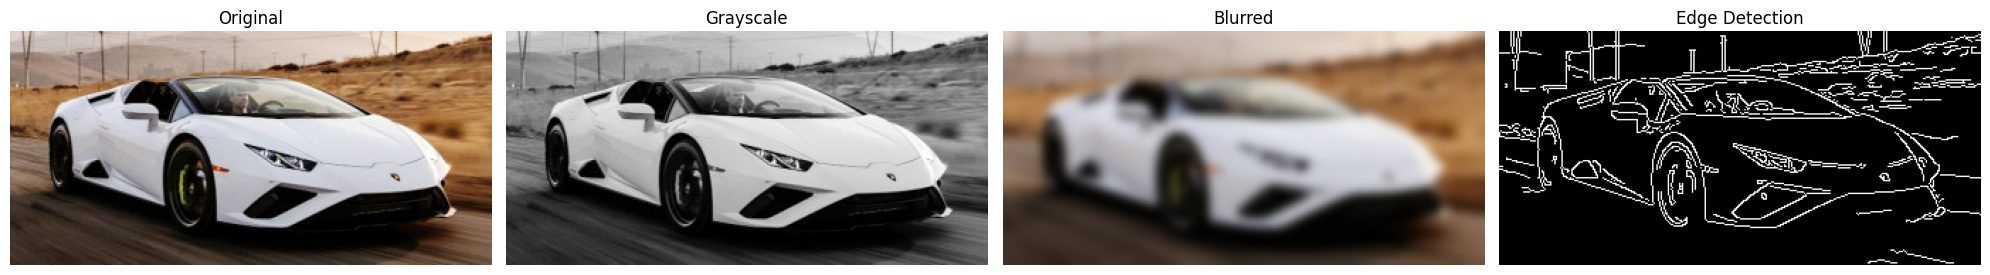

✅ 이미지 처리 완료! 크기: (165, 340, 3)


In [ ]:
# =============================================================================
# 📝 테스트 5: 이미지 업로드 및 처리 (선택사항)
# =============================================================================

def test5_upload_and_process():
    """이미지 업로드하고 처리하기 (선택사항)"""
    print("\n📁 테스트 5: 이미지 업로드 및 처리")
    print("이미지 파일을 업로드하세요...")

    try:
        # 파일 업로드
        uploaded = files.upload()

        if uploaded:
            filename = list(uploaded.keys())[0]

            # 이미지 읽기
            image_data = uploaded[filename]
            img = Image.open(io.BytesIO(image_data))
            img_array = np.array(img)

            # RGB → BGR 변환 (OpenCV용)
            if len(img_array.shape) == 3:
                img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            else:
                img_bgr = img_array

            # 크기 조정 (너무 큰 이미지 방지)
            height, width = img_bgr.shape[:2]
            if width > 800:
                scale = 800 / width
                new_width = 800
                new_height = int(height * scale)
                img_bgr = cv2.resize(img_bgr, (new_width, new_height))

            # 다양한 처리 적용
            gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(img_bgr, (21, 21), 0)
            edges = cv2.Canny(gray, 100, 200)

            # 결과 출력
            plt.figure(figsize=(20, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(gray, cmap='gray')
            plt.title('Grayscale')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
            plt.title('Blurred')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(edges, cmap='gray')
            plt.title('Edge Detection')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            print(f"✅ 이미지 처리 완료! 크기: {img_bgr.shape}")

    except Exception as e:
        print(f"❌ 업로드 중 오류: {e}")
        print("이 테스트는 건너뛰겠습니다.")

# 함수 실행 코드 추가
if __name__ == "__main__":
   test5_upload_and_process()